In [1]:
import os 
import sys 

import os 
import sys 
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if project_root not in sys.path: 
    sys.path.insert(0, project_root)

print(project_root)

/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce Paper/contrastive-abstraction-RL


In [2]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt 
import torch  
import minari 
import numpy as np
import faiss

from src.utils.sampling_states import sample_states
from src.utils.remove_dupes import remove_dupes

from src.models.cl_model import mlpCL
from src.data.TrajectorySet import TrajectorySet



In [3]:
# Resolving some weird faiss issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)
faiss.omp_set_num_threads(1)

# Solves a faiss issue with macbooks
sys.modules['faiss.swigfaiss_avx2'] = faiss

In [4]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu"
PROJECT_ROOT = project_root
TOTAL_STATES = 10_000

In [5]:
# get laplace model
model_name_1 = "laplace_cos_sim-v1.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/trained_models", model_name_1) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    laplace_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))

Found pretrained model at /Users/ray/Documents/Research Assistancy UofA 2025/Reproduce Paper/contrastive-abstraction-RL/trained_models/laplace_cos_sim-v1.ckpt, loading...


/opt/homebrew/Caskroom/miniforge/base/envs/CL_RL/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.1.post0


In [10]:
# Get states from dataset
d = sample_states(MINARI_DATASET, TOTAL_STATES,)

# get z reps
states = d["states"]
new_states = torch.as_tensor(states, dtype=torch.float32)

with torch.no_grad():
    z = laplace_model(new_states)

In [32]:
# normalize, then take PCA
z_norm = normalize(z, norm="l2", axis=1)
z_pca_norm = PCA(n_components=2).fit_transform(z_norm)

# scale, then take PCA 
scaler_laplace = StandardScaler()
scaled_z = scaler_laplace.fit_transform(z)
pca_z = PCA(n_components=2).fit_transform(scaled_z)


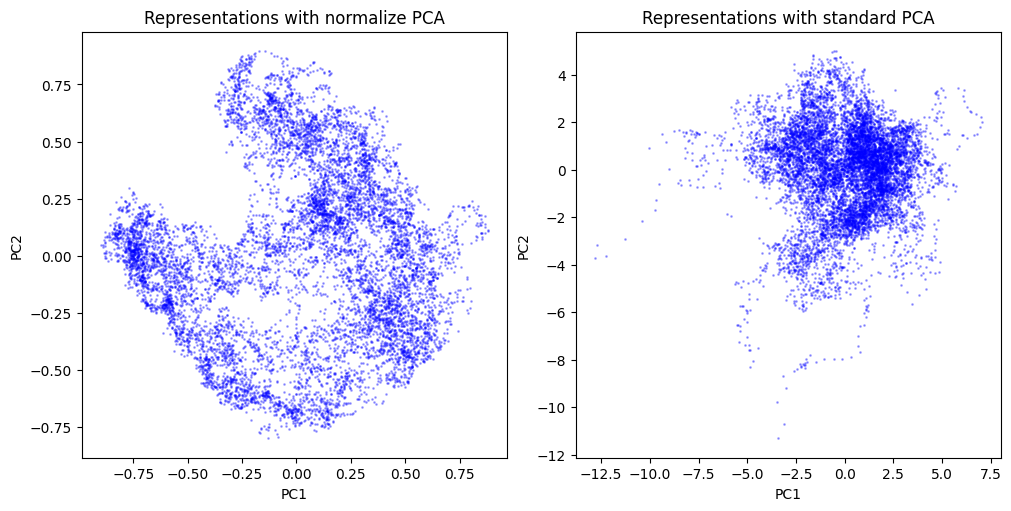

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True)
axs[0].scatter(z_pca_norm[:,0], z_pca_norm[:,1], s=1, alpha=0.3, c="blue")
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('Representations with normalize PCA')

axs[1].scatter(pca_z[:,0], pca_z[:,1], s=1, alpha=0.3, c="blue")
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_title('Representations with standard PCA')

plt.show()